In [34]:
%run utils.ipynb

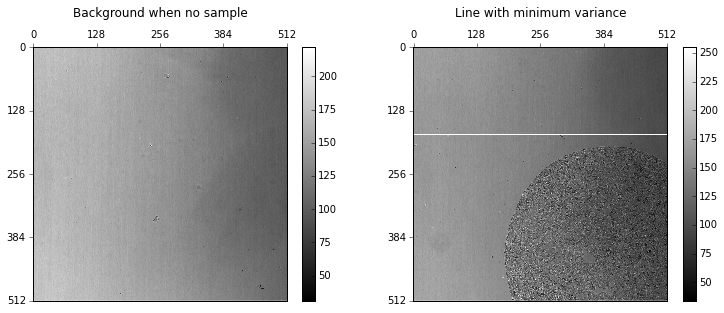

In [35]:
e = Experiment('data/experiment--2015_03_21_17_09_56')

img = imread(e.image(0,0,4,0))

fig = figure(figsize=(12.5, 10))

# uneven illumination - backgronud
ax = subplot(221)
imgplot = imshow_range(img)

image_axis(ax, ticks=range_img(512))
ax.set_title('Background when no sample', y=1.10, fontsize=12)


# line least variance
ax = subplot(222)
p1 = e.image(0,0,0,0)
img = imread(p1)

line_variance = np.var(img, axis=0)
line = np.argmin(line_variance)
img[line-1:line+1, :] = 255
imshow_range(img)
image_axis(ax, ticks=range_img(512))
ax.set_title('Line with minimum variance', y=1.10, fontsize=12)

savefig('figures/uneven_illumination.png')